&copy;  C. Lázaro, Universidad Politécnica de Valencia, 2015

# Form finding of planar flexible rods (6)

Summary of main results from 2DRodFF_3 & 2DRodFF_5 and formfinding tool for single rods

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
import scipy.special as sp
from scipy.optimize import brentq

## 1 Complex force densities

The 2D formfinding equations in complex form are

$$\mathbf{D}_l = \mathbf{C}_l^{\mathsf{T}} \,\mathbf{P}\,\mathbf{C}_l$$
$$\mathbf{D}_f = \mathbf{C}_l^{\mathsf{T}} \,\mathbf{P}\,\mathbf{C}_f $$
$$\mathbf{\gamma}_l = \mathbf{D}_l^{-1} \bigl( \mathbf{\phi}_l - \mathbf{D}_f \,\mathbf{\gamma}_f \bigr)$$

Where the diagonal elements of the force density matrix are the complex force densities
$$q_{IJ} = r_{IJ} + i \,s_{IJ}$$
$r_{IJ} = R_{IJ}/d_{IJ}$ is the tension (compression) tension density and $s_{IJ} = S_{IJ}/d_{IJ}$ the transverse force density.  
$\mathbf{C}_l$, $\mathbf{C}_f$ are the connectivity matrixes.

In [114]:
class StructuralMember:
    def __init__(self, startNode, endNode, complexq):
        self.startNode = startNode
        self.endNode = endNode
        self.complexq = complexq
        
        self.gammaA = None
        self.gammaB = None
        self.dAB = None
        self.R = None
        self.S = None
        self.MA = None
        self.MB = None
        
    def setActiveParams(self, gammaA, gammaB, MA):
        self.gammaA = gammaA
        self.gammaB = gammaB
        self.dAB = np.absolute(gammaB - gammaA)
        
        self.MA = MA
        self.R = self.complexq.real*self.dAB
        self.S = self.complexq.imag*self.dAB
        self.MB = self.MA - self.S*self.dAB
        
        self.EI = 500.
        
        

In [175]:
# Input data

# Total number of nodes
NN = 6    

# Fixed nodes
gammaF = np.array([
complex(-5., 0.),    
complex(0., 2.5),   
complex(0., -2.5),  
complex(5., 0.)
])
NF = len(gammaF)    # number of fixed nodes
print('Fixed nodes')
print(gammaF)
print

# Structural Members
# Active Members
rng_activeMember = []
rng_activeMember.append(StructuralMember(0, 2, complex(-5., 5.)))
rng_activeMember.append(StructuralMember(0, 1, complex(-5., -15.)))
rng_activeMember.append(StructuralMember(1, 5, complex(-5., 5.)))
# Tension members
rng_tensionMember = []
rng_tensionMember.append(StructuralMember(0, 3, 0.))
rng_tensionMember.append(StructuralMember(1, 4, 0.))

# Number of members
MMA = len(rng_activeMember)    # Bending active members
MMT = len(rng_tensionMember)    # Tension active members
MM = MMA + MMT

# Connectivity matrix
C = np.zeros((MM, NN))
i = 0
for member in rng_activeMember:
    C[i, member.startNode] = 1
    C[i, member.endNode] = -1
    i += 1
for member in rng_tensionMember:
    C[i, member.startNode] = 1
    C[i, member.endNode] = -1
    i += 1

CL = C[:, 0:(NN - NF)]
CF = C[:, (NN - NF):]
print('Connectivity matrix')
print(C)
print

# Force densities in kN/m corresponding to every element
q = []
for activeMember in rng_activeMember:
    q.append(activeMember.complexq)
for tensionMember in rng_tensionMember:
    q.append(tensionMember.complexq)

qQ = np.diagflat(q)
print('Complex force densities')
print(qQ)
print

# External forces
fL = np.array([
complex(0., 0.),
complex(0., 0.)
])
print('External forces')
print(fL)
print

Fixed nodes
[-5.+0.j   0.+2.5j  0.-2.5j  5.+0.j ]

Connectivity matrix
[[ 1.  0. -1.  0.  0.  0.]
 [ 1. -1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0. -1.]
 [ 1.  0.  0. -1.  0.  0.]
 [ 0.  1.  0.  0. -1.  0.]]

Complex force densities
[[-5. +5.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j -5.-15.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j -5. +5.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j]]

External forces
[ 0.+0.j  0.+0.j]



In [176]:
# Solution of the force density equations

gammaL = np.zeros(NN - NF)
DL = np.zeros((NN - NF, NN - NF))
DF = np.zeros((NN - NF, NF))

DL = np.dot(np.transpose(CL), np.dot(qQ, CL))
DF = np.dot(np.transpose(CL), np.dot(qQ, CF))

gammaL = np.linalg.solve(DL, fL - np.dot(DF, gammaF))
print('Free node coordinates')
print(gammaL)
print

Free node coordinates
[ 0.29411765+1.17647059j -0.29411765-1.17647059j]



In [177]:
rng_gamma = np.concatenate((gammaL, gammaF), axis=0)

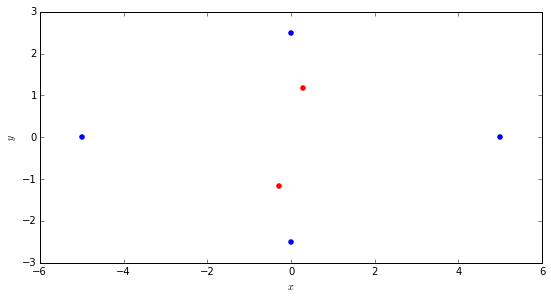

In [178]:
fig = plt.figure(figsize=(9,9))

ax = fig.gca(aspect='equal')
ax.scatter(gammaF.real, gammaF.imag, color='b')
ax.scatter(gammaL.real, gammaL.imag, color='r')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

## 2 Form-finding tool for a single rod

In [179]:
def omegaDeltaomega(muA, muB, flag, k):
    if (k<1E-8):
        omega_0 = -.5*np.pi
        Deltaomega_0 = np.pi
    else:
        if (muA >= 0):
            omega_0 = np.arccos(np.pi*muA/2./k)                                  # OK
            Deltaomega_0 = np.arccos(np.pi*muB/2./k) - omega_0                   # OK
            omega_1 = -np.arccos(np.pi*muA/2./k)                                 # OK
            Deltaomega_1 = np.arccos(np.pi*muB/2./k) - omega_1                   # OK
        else:
            omega_1 = np.arccos(np.pi*muA/2./k) - 2*np.pi
            omega_0 = -np.arccos(np.pi*muA/2./k)                                 # OK
            if (muB >= 0):
                Deltaomega_1 = -np.arccos(np.pi*muB/2./k) - omega_1
                Deltaomega_0 = -np.arccos(np.pi*muB/2./k) - omega_0              # OK
            else:
                Deltaomega_1 = -np.arccos(np.pi*muB/2./k) - omega_1
                Deltaomega_0 = -np.arccos(np.pi*muB/2./k) - omega_0              # OK
        
    if (flag == 0):
        print('omega_0 = {0:.5f},    Deltaomega_0 = {1:.5f}'.format(omega_0, Deltaomega_0))
        return(omega_0, Deltaomega_0)
    else:
        print('omega_1 = {0:.5f},    Deltaomega_1 = {1:.5f}'.format(omega_1, Deltaomega_1))
        return(omega_1, Deltaomega_1)
    

In [180]:
def lmbdk(muA, muB, flag, k):
    wA, Deltaw = omegaDeltaomega(muA, muB, flag, k)
    Deltaxi = (2*(sp.ellipeinc(wA+Deltaw,k**2) - sp.ellipeinc(wA,k**2)) - (sp.ellipkinc(wA+Deltaw,k**2) - sp.ellipkinc(wA,k**2)))/np.pi
    Deltaeta = -2*k*(np.cos(wA+Deltaw) - np.cos(wA))/np.pi
    lmbd = np.sqrt(Deltaxi**2 + Deltaeta**2)
    return(lmbd)

In [181]:
class F:
    def __init__(self, muA, muB, lmbdAB, flag):
        self.muA = muA
        self.muB = muB
        self.lmbdAB = lmbdAB
        self.flag = flag
        
    def __call__(self, k):
        lmbd = lmbdk(self.muA, self.muB, self.flag, k)
        return(self.lmbdAB - lmbd)

In [182]:
class Elastica:
    def __init__(self, gammaA=None, gammaB=None, R=None, MA=None, MB=None, EI=None):
        self.gammaA = gammaA
        self.gammaB = gammaB
        self.beta = np.angle(gammaB - gammaA)
        
        self.R = R
        self.MA = MA
        self.MB = MB
        self.EI = EI
        
        self.dAB = np.absolute(gammaB - gammaA)        # Distance between rod end-sections
        self.S = (MA - MB)/self.dAB                    # Shear force S (perpendicular to R)
        self.P = - np.sqrt(R**2 + self.S**2)           # Invariant compressive force
        self.lcrit = np.pi*np.sqrt(EI/abs(self.P))     # Critical length
        
        self.lmbdAB = self.dAB/self.lcrit              # Normalized distance
        self.muA = MA/abs(self.P)/self.lcrit           # Adimensional moments
        self.muB = MB/abs(self.P)/self.lcrit
        
        self.flag = 0
        
        self.k = None                                  # k parameter, to be computed
        self.HmodP = None                              # H/|P| = -cos(theta_0)
        
        self.alpha = None
        self.phiA = None
        self.phiB = None
    
    def data(self):
        print('  dAB = {0:8.4f}  m'.format(self.dAB))
        print('    R = {0:8.4f} kN,          S = {1:8.4f} kN'.format(self.R, self.S))
        print('    P = {0:8.4f} kN'.format(self.P))
        print('lcrit = {0:8.4f} m,    lambdaAB = {1:8.4f}'.format(self.lcrit, self.lmbdAB))
        print('   MA = {0:8.4f},            MB = {1:8.4f}'.format(self.MA, self.MB))
        print('  muA = {0:8.4f},           muB = {1:8.4f}'.format(self.muA, self.muB))
    
    def compute_k(self):
        muA = self.muA
        muB = self.muB
        lmbdAB = self.lmbdAB
        flag = self.flag
        
        if (abs(muA)<1E-8 and abs(muB)< 1E-8):
            kmin = 0.
        else:
            kmin = max(np.pi*abs(muA)/2., np.pi*abs(muB)/2.) # Lowest possible value for k
        print('kmin = {0:.5f}'.format(kmin))
        
        rng_k = np.arange(kmin, 1., 0.05)
        rng_f = []
        flag = 0
        print('\nflag = {}'.format(flag))
        i = 0
        for k in rng_k:
            print(i)
            lmbd = lmbdk(muA, muB, flag, k)
            f = lmbdAB - lmbd
            rng_f.append(f)
            print('k = {0:.5f},    lmbd = {1:.5f},    f = {2:.5f},'.format(k, lmbd, f))
            i += 1
        rng_signf = np.sign(np.asarray(rng_f))
        rng_index = rng_signf[:-1] + rng_signf[1:]
        rng_index = rng_index.tolist()
        print(rng_index)
        
        if 0. in rng_index:
            index00 = rng_index.index(0.)
            index01 = len(rng_index) - (rng_index[::-1]).index(0.) - 1
            print(index00, index01)
        else:
            rng_f = []
            flag = 1
            print('\nflag = {}'.format(flag))
            i = 0
            for k in rng_k:
                print(i)
                lmbd = lmbdk(muA, muB, flag, k)
                f = lmbdAB - lmbd
                rng_f.append(f)
                print('k = {0:.5f},    lmbd = {1:.5f},    f = {2:.5f},'.format(k, lmbd, f))
                i += 1
            rng_signf = np.sign(np.asarray(rng_f))
            rng_index = rng_signf[:-1] + rng_signf[1:]
            rng_index = rng_index.tolist()
            print(rng_index)
            
            index00 = rng_index.index(0.)
            index01 = len(rng_index) - (rng_index[::-1]).index(0.) - 1
            #print(index00, index01)        
                
        HmodP00 = -np.cos(2*np.arcsin(rng_k[index00]))
        HmodP01 = -np.cos(2*np.arcsin(rng_k[index01]))
        print('H/|P|00 = {0:.5f},    H/|P|01 = {1:.5f}'.format(HmodP00, HmodP01))
        if (index00==index01):
            index0 = index00
        else:
            if (HmodP00<=HmodP01):
                index0 = index00
            else:
                index0 = index01
        print(index0)
        
        ka = rng_k[index0]
        kb = rng_k[index0+1]
        print('ka = {0:.5f},    kb = {1:.5f}'.format(ka, kb))
        
        f = F(muA, muB, lmbdAB, flag)
        self.k = brentq(f, ka, kb)    # Solve for k
        self.HmodP = -np.cos(2*np.arcsin(self.k))
        self.flag = flag
        print('k = {0:.5f},    H/|P| = {1:.5f}'.format(self.k, self.HmodP))
        
    def compute_Config(self):
        gammaA = self.gammaA
        beta = self.beta
        muA = self.muA
        muB = self.muB
        lcrit = self.lcrit
        flag = self.flag
        try:
            k = float(self.k)
        except ValueError:
            raise ValueError('Method .compute_k has to be executed first')
                    
        nVertex = 101
        (wA, Deltaw) = omegaDeltaomega(muA, muB, flag, k)
        if (wA>0 and Deltaw<0):
            wA = -wA
            Deltaw = -Deltaw
        rng_w = np.linspace(wA, wA+Deltaw, nVertex)
        
        rng_zeta = []
        rng_xi = []
        rng_eta = []
        for w in rng_w:
            zeta = (sp.ellipkinc(w,k**2) + sp.ellipk(k**2))/np.pi
            xi = 2*(sp.ellipeinc(w,k**2) + sp.ellipe(k**2))/np.pi - zeta
            eta = -2*k*np.cos(w)/np.pi
            rng_zeta.append(zeta)
            rng_xi.append(xi)
            rng_eta.append(eta)
        rng_xi = np.asarray(rng_xi)
        rng_eta = np.asarray(rng_eta)

        alpha = np.arctan2(rng_eta[-1]-rng_eta[0], rng_xi[-1]-rng_xi[0])
        print('beta = {0:.5f}    alpha = {1:.5f}'.format(beta, alpha))
        rng_x = gammaA.real + np.cos(beta - alpha)*lcrit*(rng_xi - rng_xi[0]) - np.sin(beta - alpha)*lcrit*(rng_eta - rng_eta[0])
        rng_y = gammaA.imag + np.sin(beta - alpha)*lcrit*(rng_xi - rng_xi[0]) + np.cos(beta - alpha)*lcrit*(rng_eta - rng_eta[0])
        
        phiA = 2*np.arcsin(k*np.sin(wA)) + beta - alpha
        phiB = 2*np.arcsin(k*np.sin(wA + Deltaw)) + beta - alpha
        print('phiA = {0:.5f}    phiB = {1:.5f}'.format(phiA, phiB))
        
        self.alpha = alpha
        self.phiA = phiA
        self.phiB = phiB
        
        #return(rng_xi, rng_eta)
        return(rng_x, rng_y)
    
    def plot(self):
        fig = plt.figure(figsize=(9,9))
        ax = fig.gca(aspect='equal')
        
        (x, y) = self.compute_Config()
        ax.plot(x, y, color ='b')
        ax.grid()
        ax.set_xlabel(r'$x$')
        ax.set_ylabel(r'$y$')
        

In [183]:
test_element = Elastica(gammaA=complex(0.0), gammaB=complex(10.,0.), R=-10., MA=0., MB=-120., EI=500.)

In [184]:
test_element.data()

  dAB =  10.0000  m
    R = -10.0000 kN,          S =  12.0000 kN
    P = -15.6205 kN
lcrit =  17.7741 m,    lambdaAB =   0.5626
   MA =   0.0000,            MB = -120.0000
  muA =   0.0000,           muB =  -0.4322


In [185]:
test_element.compute_k()

kmin = 0.67892

flag = 0
0
omega_0 = 1.57080,    Deltaomega_0 = 1.57080
k = 0.67892,    lmbd = 0.52169,    f = 0.04093,
1
omega_0 = 1.57080,    Deltaomega_0 = 1.19826
k = 0.72892,    lmbd = 0.45326,    f = 0.10935,
2
omega_0 = 1.57080,    Deltaomega_0 = 1.05849
k = 0.77892,    lmbd = 0.43523,    f = 0.12739,
3
omega_0 = 1.57080,    Deltaomega_0 = 0.95974
k = 0.82892,    lmbd = 0.43320,    f = 0.12942,
4
omega_0 = 1.57080,    Deltaomega_0 = 0.88269
k = 0.87892,    lmbd = 0.44782,    f = 0.11479,
5
omega_0 = 1.57080,    Deltaomega_0 = 0.81960
k = 0.92892,    lmbd = 0.49058,    f = 0.07204,
6
omega_0 = 1.57080,    Deltaomega_0 = 0.76639
k = 0.97892,    lmbd = 0.62941,    f = -0.06680,
[2.0, 2.0, 2.0, 2.0, 2.0, 0.0]
(5, 5)
H/|P|00 = 0.72579,    H/|P|01 = 0.72579
5
ka = 0.92892,    kb = 0.97892
omega_0 = 1.57080,    Deltaomega_0 = 0.81960
omega_0 = 1.57080,    Deltaomega_0 = 0.76639
omega_0 = 1.57080,    Deltaomega_0 = 0.79094
omega_0 = 1.57080,    Deltaomega_0 = 0.78412
omega_0 = 1.57080, 

omega_0 = 1.57080,    Deltaomega_0 = 0.78178
beta = 0.00000    alpha = 2.26553
phiA = 0.33503    phiB = -0.75947


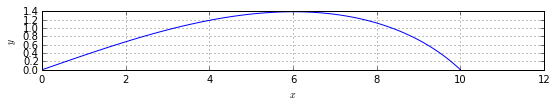

In [186]:
test_element.plot()

## 3 Structural form-finding (1)

In [187]:
M2 = 0.
nextStartM = M2
for activeMember in rng_activeMember:
    startNode = activeMember.startNode
    endNode = activeMember.endNode
    activeMember.setActiveParams(rng_gamma[startNode], rng_gamma[endNode], nextStartM)
    nextStartM = activeMember.MB

In [188]:
rng_activeMember[2].dAB

5.4232614454664043

In [189]:
rng_elastica = []
for activeMember in rng_activeMember:
    startNode = activeMember.startNode
    endNode = activeMember.endNode
    R = activeMember.R
    MA = activeMember.MA
    MB = activeMember.MB
    EI = activeMember.EI
    rng_elastica.append(Elastica(rng_gamma[startNode], rng_gamma[endNode], R, MA, MB, EI))

  dAB =   5.4233  m
    R = -27.1163 kN,          S =  27.1163 kN
    P = -38.3482 kN
lcrit =  11.3439 m,    lambdaAB =   0.4781
   MA =   0.0000,            MB = -147.0588
  muA =   0.0000,           muB =  -0.3381
kmin = 0.53101

flag = 0
0
omega_0 = 1.57080,    Deltaomega_0 = 1.57080
k = 0.53101,    lmbd = 0.51087,    f = -0.03279,
1
omega_0 = 1.57080,    Deltaomega_0 = 1.15290
k = 0.58101,    lmbd = 0.40742,    f = 0.07066,
2
omega_0 = 1.57080,    Deltaomega_0 = 1.00010
k = 0.63101,    lmbd = 0.37221,    f = 0.10587,
3
omega_0 = 1.57080,    Deltaomega_0 = 0.89425
k = 0.68101,    lmbd = 0.35173,    f = 0.12635,
4
omega_0 = 1.57080,    Deltaomega_0 = 0.81308
k = 0.73101,    lmbd = 0.34080,    f = 0.13728,
5
omega_0 = 1.57080,    Deltaomega_0 = 0.74763
k = 0.78101,    lmbd = 0.33822,    f = 0.13986,
6
omega_0 = 1.57080,    Deltaomega_0 = 0.69319
k = 0.83101,    lmbd = 0.34505,    f = 0.13303,
7
omega_0 = 1.57080,    Deltaomega_0 = 0.64692
k = 0.88101,    lmbd = 0.36557,    f = 0.11251

ValueError: 0.0 is not in list

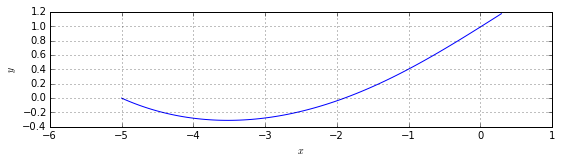

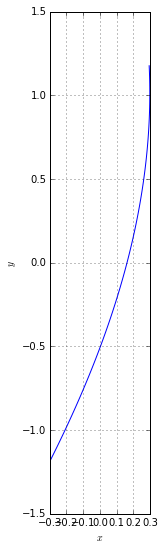

In [190]:
for element in rng_elastica:
    element.data()
    element.compute_k()
    element.plot()